In [1]:
from pyspark import SparkContext, SparkConf
from pyspark import HiveContext
from pyspark.sql import SQLContext
import datetime
import pandas as pd
import numpy as np
import random
np.random.seed(5)
confs = SparkConf()
confs.set("spark.driver.maxResultSize","15g")
confs.set("spark.driver.memory","30g")
confs.set("spark.dynamicAllocation.enabled","true")
confs.set("spark.dynamicAllocation.minExecutors","1")
confs.set("spark.dynamicAllocation.maxExecutors","600")
confs.set("spark.task.maxFailures","15")
confs.set("spark.yarn.max.executor.failures","1000")
confs.set("spark.dynamicAllocation.executorIdleTimeout","400")
confs.set("spark.shuffle.service.enabled","true")
confs.set("spark.executor.cores","1")
confs.set("spark.executor.memory","8g")
confs.set("spark.network.timeout","240000")
confs.set("spark.akka.frameSize","512")
confs.set("spark.yarn.dist.archives","hdfs://cls04pri/user/vvelocci/RoutesNYC.zip#anaconda")
sc = SparkContext(conf=confs,master="yarn-client")                               
hc = HiveContext(sc)

In [2]:
import folium
from datetime import datetime
import dateutil.parser
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import os

In [3]:
def location_df(sql_query):
    df = hc.sql(sql_query).toPandas()
    df[['latitude', 'longitude']] = df[['latitude', 'longitude']].astype(float)
    df['local_time'] = df['local_time'].apply(lambda x: dateutil.parser.parse(x))

    def f(row):
        if row['device_id'] in ['000003059756761','310120219347939']: # They're the same device:
            return 'iPhone'
        else:
            return 'iPad'
    df['model'] = df.apply(f, axis=1)
    def get_hour(row):
        return row['local_time'].hour
    df['local_hour'] = df.apply(get_hour, axis=1)
    def device_model(row):
        if row['device_id'] in ['000003059756761','310120219347939']:
            return 'iPhone'
        else:
            return 'iPad'
    df['model'] = df.apply(device_model, axis=1)
    def same(row):
        if row == '000003059756761':
            return '310120219347939'
        elif row == '000002013223727':
            return '310120131467908'
        else:
            return row
    df['device_id'] = df['device_id'].apply(same)
    return df

In [4]:
df_0604 = location_df("select * from datascience.vince_dart")

In [5]:
df_0604.head()

,device_id,latitude,longitude,lateration_method,local_time,local_time_zone,utc_time,service_option,duration,device_type,...,cascade_id,conf_type,conf_radius,cfc_id,imei,stus_cd,dt,imsi_id,model,local_hour
0,310120131467908,40.985095,-72.177394,NULL,2017-06-04 02:16:41.109,EDT,2017-06-04 06:16:41.109,NULL,1,NULL,...,NY54XC837,4,685,116100000,35565307050667,1,20170604,310120131467908,iPad,2
1,310120131467908,40.985095,-72.177394,NULL,2017-06-03 18:54:38.141,EDT,2017-06-03 22:54:38.141,NULL,2,NULL,...,NY54XC837,4,685,115100000,35565307050667,1,20170604,310120131467908,iPad,18
2,310120131467908,40.985095,-72.177394,NULL,2017-06-04 02:16:54.887,EDT,2017-06-04 06:16:54.887,NULL,1,NULL,...,NY54XC837,4,685,116100000,35565307050667,1,20170604,310120131467908,iPad,2
3,310120131467908,41.012256,-72.204206,NULL,2017-06-03 19:02:37.327,EDT,2017-06-03 23:02:37.327,NULL,1,NULL,...,NY54XC837,4,637,111103121,35565307050667,1,20170604,310120131467908,iPad,19
4,310120131467908,40.985095,-72.177394,NULL,2017-06-03 13:07:27.455,EDT,2017-06-03 17:07:27.455,NULL,1,NULL,...,NY54XC837,4,685,116100000,35565307050667,1,20170604,310120131467908,iPad,13


In [6]:
device_counts_0604 = df_0604.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0604['model'] = device_counts_0604['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0604

,device_id,count,model
0,310120131467908,576.0,iPad
1,310120140923611,1.0,iPad
2,310120219347939,1919.0,iPhone


In [41]:
# def f(row):
#     if row['device_id'] in ['000003059756761','310120219347939']: # They're the same device:
#         return 'iPhone'
#     else:
#         return 'iPad'
# df_0604_counts = hc.sql("select device_id, count(device_id) from datascience.vince_dart group by device_id").toPandas()
# df_0604_counts['model'] = df_0604_counts.apply(f, axis=1)
# df_0604_counts
# df_0607_counts = hc.sql("select device_id, count(device_id) from datascience.vince_dart2 group by device_id").toPandas()
# df_0607_counts['model'] = df_0607_counts.apply(f, axis=1)
# df_0607_counts # Could the switch in device_ids with most counts be due to iPhone vs iPad?

In [7]:
df_0607 = location_df("select * from datascience.vince_dart2")

In [8]:
device_counts_0607 = df_0607.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0607['model'] = device_counts_0607['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0607

,device_id,count,model
0,310120131467908,730.0,iPad
1,310120219347939,271.0,iPhone


In [43]:
df_0604.loc[0,'local_time']

Timestamp('2017-06-04 02:16:41.109000')

In [9]:
print len(df_0607['latitude'])

1001


In [38]:
# map = folium.Map(location=[40.7128, -74.0059], zoom_start=14)
# # #map.simple_marker

# # # replace simple_markers by MarkerCluster plugin
# # from folium.plugins import MarkerCluster
# # # map.simple_marker(
# # # location = [each[1]['Y'],each[1]['X']], 
# # # clustered_marker = True)
# lons = []
# lats = []
# n = len(df_0604['latitude'])

# for each in df_0604[0:n].iterrows():
#      lon = each[1]['longitude']
#      lons.append(lon) 
#      lat = each[1]['latitude']
#      lats.append(lat)
# # # build and display(map) 
# # # correct the markers adding clustered markers
# locations = list(zip(lats, lons))
# popups = ['{}'.format(loc) for loc in locations]
# map.add_child(MarkerCluster(locations=locations, popups=popups))

In [98]:
map_1 = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0604['latitude'])

for i in range(n):
      folium.RegularPolygonMarker([df_0604.loc[i,'latitude'], df_0604.loc[i,'longitude']], popup=str(df_0604.loc[i,'model']), fill_color='red', number_of_sides=5, radius=5).add_to(map_1)
map_1.save(os.path.join('', '0604_polygon.html'))

In [47]:
# map2 = folium.Map(location=[40.7128, -74.0059], zoom_start=14)
# #map.simple_marker

# # replace simple_markers by MarkerCluster plugin
# from folium.plugins import MarkerCluster
# # map.simple_marker(
# # location = [each[1]['Y'],each[1]['X']], 
# # clustered_marker = True)
# lons = []
# lats = []
# n = len(df_0607['latitude'])

# for each in df_0607[0:n].iterrows():
#     lon = each[1]['longitude']
#     lons.append(lon) 
#     lat = each[1]['latitude']
#     lats.append(lat)
# # build and display(map) 
# # correct the markers adding clustered markers
# locations = list(zip(lats, lons))
# popups = ['{}'.format(loc) for loc in locations]
# map2.add_child(MarkerCluster(locations=locations, popups=popups))

In [100]:
map_2 = folium.Map(location=[40.7128, -74.0059],
                    zoom_start=11,
                    tiles='Stamen Toner')
n = len(df_0607['latitude'])

for i in range(n):
     folium.RegularPolygonMarker([df_0607.loc[i,'latitude'], df_0607.loc[i,'longitude']], popup=str(df_0607.loc[i,'model']), fill_color='green', number_of_sides=5, radius=5).add_to(map_2)
map_2.save(os.path.join('', '0607_polygon.html'))

In [103]:
map_combined = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0607['latitude'])
m = len(df_0604['latitude'])

for i in range(n):
      folium.RegularPolygonMarker([df_0607.loc[i,'latitude'], df_0607.loc[i,'longitude']], popup=str(df_0607.loc[i,'model'])+' weekday', fill_color='green', number_of_sides=5, radius=5).add_to(map_combined)
for i in range(m):
      folium.RegularPolygonMarker([df_0604.loc[i,'latitude'], df_0604.loc[i,'longitude']], popup=str(df_0604.loc[i,'model'])+' weekend', fill_color='red', number_of_sides=3, radius=5).add_to(map_combined)
map_combined.save(os.path.join('', '0604_0607_combined_polygon.html'))

In [10]:
df_0604_iPhone = df_0604[df_0604['model']=='iPhone'].reset_index()
df_0604_iPad = df_0604[df_0604['model']=='iPad'].reset_index()
df_0607_iPhone = df_0607[df_0607['model']=='iPhone'].reset_index()
df_0607_iPad = df_0607[df_0607['model']=='iPad'].reset_index()

In [105]:
iPhone_map = folium.Map(location=[40.7128, -74.0059],
                      zoom_start=11,
                      tiles='Stamen Toner')
n = len(df_0607_iPhone['latitude'])
m = len(df_0604_iPhone['latitude'])

for i in range(n):
       folium.RegularPolygonMarker([df_0607_iPhone.loc[i,'latitude'], df_0607_iPhone.loc[i,'longitude']], popup=str(df_0607_iPhone.loc[i,'model'])+' weekday', fill_color='green', number_of_sides=5, radius=5).add_to(iPhone_map)
for i in range(m):
       folium.RegularPolygonMarker([df_0604_iPhone.loc[i,'latitude'], df_0604_iPhone.loc[i,'longitude']], popup=str(df_0604_iPhone.loc[i,'model'])+' weekend', fill_color='red', number_of_sides=3, radius=5).add_to(iPhone_map)
iPhone_map.save(os.path.join('', 'iPhone_map.html'))

In [14]:
hour_counts_0604 = df_0604.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
hour_counts_0607 = df_0607.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()

/home/vvelocci/.conda/envs/RoutesNYC/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


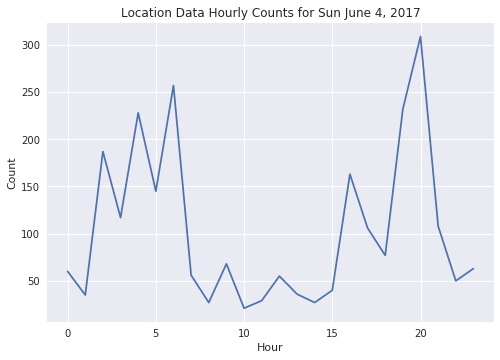

In [16]:
fig = plt.figure()
plt.title('Location Data Hourly Counts for Sun June 4, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0604['local_hour'], hour_counts_0604['count']);

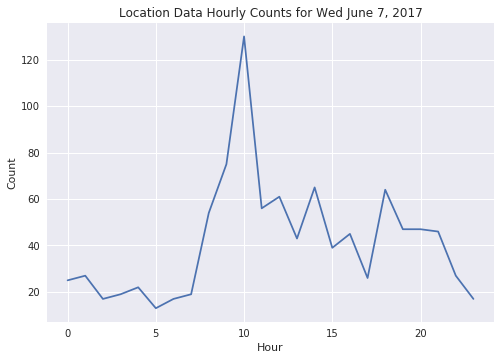

In [17]:
fig = plt.figure()
plt.title('Location Data Hourly Counts for Wed June 7, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0607['local_hour'], hour_counts_0607['count']);

In [73]:
# m = folium.Map([40.7128, -74.0059], tiles='stamentoner', zoom_start=12)
# data_0604 = [list(a) for a in zip(df_0604['latitude'],df_0604['longitude'])]
# HeatMap(data_0604).add_to(m)
# m.save(os.path.join('', '0604_Heatmap.html'))
# m

In [75]:
# m = folium.Map([40.7128, -74.0059], tiles='stamentoner', zoom_start=12)
# data_0607 = [list(a) for a in zip(df_0607['latitude'],df_0607['longitude'])]
# HeatMap(data_0607).add_to(m)
# m.save(os.path.join('', '0607_Heatmap.html'))
# m

In [19]:
df_0603 = location_df("select * from datascience.vince_dart3")
device_counts_0603 = df_0603.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0603['model'] = device_counts_0603['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0603

,device_id,count,model
0,310120131467908,1070.0,iPad
1,310120219347939,893.0,iPhone


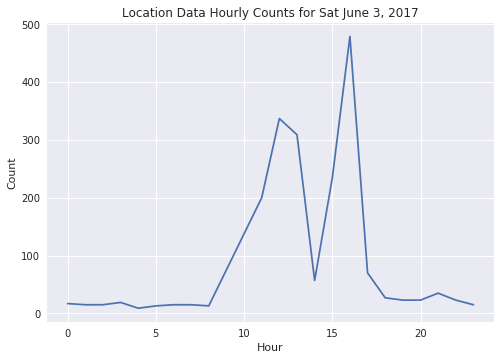

In [21]:
hour_counts_0603 = df_0603.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
fig = plt.figure()
plt.title('Location Data Hourly Counts for Sat June 3, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0603['local_hour'], hour_counts_0603['count']);

In [20]:
map_Sat = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0603['latitude'])

for i in range(n):
    if df_0603.loc[i,'model'] == 'iPhone':
        folium.RegularPolygonMarker([df_0603.loc[i,'latitude'], df_0603.loc[i,'longitude']], popup=str(df_0603.loc[i,'model'])+str(df_0603.loc[i,'local_time']), fill_color='red', number_of_sides=5, radius=5).add_to(map_Sat)
    elif df_0603.loc[i,'model'] == 'iPad':
        folium.RegularPolygonMarker([df_0603.loc[i,'latitude'], df_0603.loc[i,'longitude']], popup=str(df_0603.loc[i,'model'])+str(df_0603.loc[i,'local_time']), fill_color='blue', number_of_sides=3, radius=5).add_to(map_Sat)
map_Sat.save(os.path.join('', '0603_polygon.html'))

In [5]:
df_0605 = location_df('select * from datascience.vince_dart4')
device_counts_0605 = df_0605.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0605['model'] = device_counts_0605['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0605

,device_id,count,model
0,310120131467908,535.0,iPad
1,310120219347939,412.0,iPhone


/home/vvelocci/.conda/envs/RoutesNYC/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


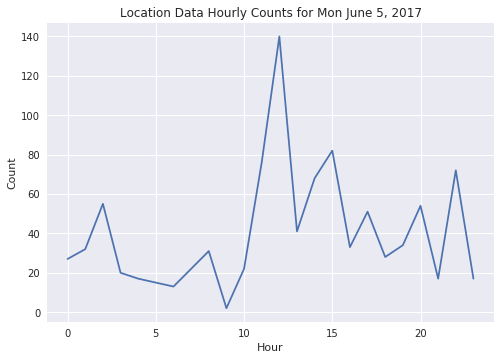

In [7]:
hour_counts_0605 = df_0605.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
fig = plt.figure()
plt.title('Location Data Hourly Counts for Mon June 5, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0605['local_hour'], hour_counts_0605['count']);

In [8]:
map_Mon = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0605['latitude'])

for i in range(n):
    if df_0605.loc[i,'model'] == 'iPhone':
        folium.RegularPolygonMarker([df_0605.loc[i,'latitude'], df_0605.loc[i,'longitude']], popup=str(df_0605.loc[i,'model']), fill_color='red', number_of_sides=5, radius=5).add_to(map_Mon)
    elif df_0605.loc[i,'model'] == 'iPad':
        folium.RegularPolygonMarker([df_0605.loc[i,'latitude'], df_0605.loc[i,'longitude']], popup=str(df_0605.loc[i,'model']), fill_color='blue', number_of_sides=3, radius=5).add_to(map_Mon)
map_Mon.save(os.path.join('', '0605_polygon.html'))

In [9]:
df_0606 = location_df('select * from datascience.vince_dart5')
device_counts_0606 = df_0606.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0606['model'] = device_counts_0606['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0606

,device_id,count,model
0,310120131467908,784.0,iPad
1,310120219347939,231.0,iPhone


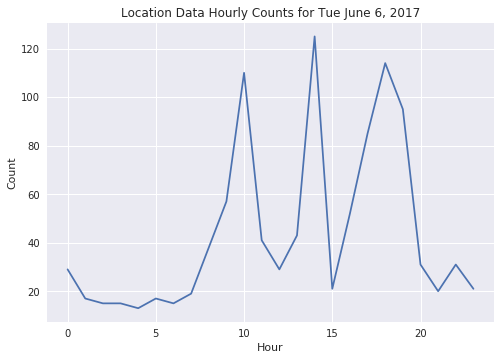

In [10]:
hour_counts_0606 = df_0606.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
fig = plt.figure()
plt.title('Location Data Hourly Counts for Tue June 6, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0606['local_hour'], hour_counts_0606['count']);

In [11]:
map_Tue = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0606['latitude'])

for i in range(n):
    if df_0606.loc[i,'model'] == 'iPhone':
        folium.RegularPolygonMarker([df_0606.loc[i,'latitude'], df_0606.loc[i,'longitude']], popup=str(df_0606.loc[i,'model']), fill_color='red', number_of_sides=5, radius=5).add_to(map_Tue)
    elif df_0606.loc[i,'model'] == 'iPad':
        folium.RegularPolygonMarker([df_0606.loc[i,'latitude'], df_0606.loc[i,'longitude']], popup=str(df_0606.loc[i,'model']), fill_color='blue', number_of_sides=3, radius=5).add_to(map_Tue)
map_Tue.save(os.path.join('', '0606_polygon.html'))

In [12]:
df_0608 = location_df('select * from datascience.vince_dart6')
device_counts_0608 = df_0608.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0608['model'] = device_counts_0608['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0608

,device_id,count,model
0,310120131467908,578.0,iPad
1,310120219347939,287.0,iPhone


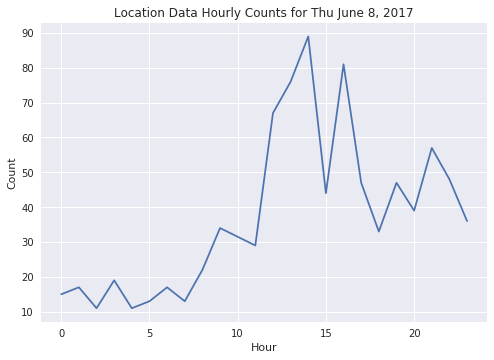

In [15]:
hour_counts_0608 = df_0608.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
fig = plt.figure()
plt.title('Location Data Hourly Counts for Thu June 8, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0608['local_hour'], hour_counts_0608['count']);

In [16]:
map_Thu = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0608['latitude'])

for i in range(n):
    if df_0608.loc[i,'model'] == 'iPhone':
        folium.RegularPolygonMarker([df_0608.loc[i,'latitude'], df_0608.loc[i,'longitude']], popup=str(df_0608.loc[i,'model']), fill_color='red', number_of_sides=5, radius=5).add_to(map_Thu)
    elif df_0608.loc[i,'model'] == 'iPad':
        folium.RegularPolygonMarker([df_0608.loc[i,'latitude'], df_0608.loc[i,'longitude']], popup=str(df_0608.loc[i,'model']), fill_color='blue', number_of_sides=3, radius=5).add_to(map_Thu)
map_Thu.save(os.path.join('', '0608_polygon.html'))

In [21]:
df_0609 = location_df('select * from datascience.vince_dart7')
device_counts_0609 = df_0609.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0609['model'] = device_counts_0609['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0609

,device_id,count,model
0,310120131467908,736.0,iPad
1,310120219347939,473.0,iPhone


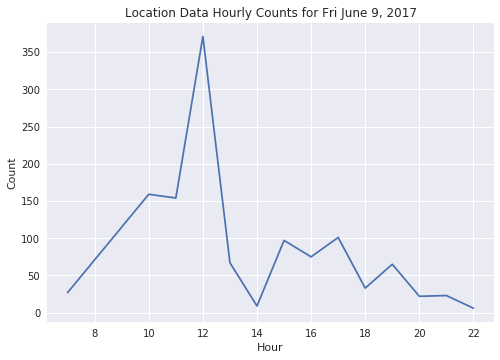

In [22]:
hour_counts_0609 = df_0609.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
fig = plt.figure()
plt.title('Location Data Hourly Counts for Fri June 9, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0609['local_hour'], hour_counts_0609['count']);

In [23]:
map_Fri = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0609['latitude'])

for i in range(n):
    if df_0609.loc[i,'model'] == 'iPhone':
        folium.RegularPolygonMarker([df_0609.loc[i,'latitude'], df_0609.loc[i,'longitude']], popup=str(df_0609.loc[i,'model'])+str(df_0609.loc[i,'local_time']), fill_color='red', number_of_sides=5, radius=5).add_to(map_Fri)
    elif df_0609.loc[i,'model'] == 'iPad':
        folium.RegularPolygonMarker([df_0609.loc[i,'latitude'], df_0609.loc[i,'longitude']], popup=str(df_0609.loc[i,'model'])+str(df_0609.loc[i,'local_time']), fill_color='blue', number_of_sides=3, radius=5).add_to(map_Fri)
map_Fri.save(os.path.join('', '0609_polygon.html'))

In [24]:
df_0609

,device_id,latitude,longitude,lateration_method,local_time,local_time_zone,utc_time,service_option,duration,device_type,...,cascade_id,conf_type,conf_radius,cfc_id,imei,stus_cd,dt,imsi_id,model,local_hour
0,310120131467908,41.013378,-72.204841,NULL,2017-06-08 20:15:00.366,EDT,2017-06-09 00:15:00.366,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,20
1,310120131467908,41.012256,-72.204206,NULL,2017-06-08 10:45:17.212,EDT,2017-06-08 14:45:17.212,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,10
2,310120131467908,40.984905,-72.177929,NULL,2017-06-08 17:21:25.502,EDT,2017-06-08 21:21:25.502,NULL,1,NULL,...,NY54XC837,4,677,115100000,35565307050667,1,20170609,310120131467908,iPad,17
3,310120131467908,41.012256,-72.204206,NULL,2017-06-08 10:32:29.283,EDT,2017-06-08 14:32:29.283,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,10
4,310120131467908,41.012256,-72.204206,NULL,2017-06-08 15:04:27.700,EDT,2017-06-08 19:04:27.700,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,15
5,310120131467908,41.012256,-72.204206,NULL,2017-06-08 10:08:11.616,EDT,2017-06-08 14:08:11.616,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,10
6,310120131467908,41.013378,-72.204841,NULL,2017-06-08 17:20:25.272,EDT,2017-06-08 21:20:25.272,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,17
7,310120131467908,40.984905,-72.177929,NULL,2017-06-08 15:10:00.068,EDT,2017-06-08 19:10:00.068,NULL,2,NULL,...,NY54XC837,4,677,115100000,35565307050667,1,20170609,310120131467908,iPad,15
8,310120131467908,41.013378,-72.204841,NULL,2017-06-08 10:49:15.313,EDT,2017-06-08 14:49:15.313,NULL,1,NULL,...,NY54XC837,4,563,111103121,35565307050667,1,20170609,310120131467908,iPad,10
9,310120131467908,40.984905,-72.177929,NULL,2017-06-08 15:00:07.939,EDT,2017-06-08 19:00:07.939,NULL,1,NULL,...,NY54XC837,4,677,115100000,35565307050667,1,20170609,310120131467908,iPad,15


In [4]:
df_0610 = location_df('select * from datascience.vince_dart8')
device_counts_0610 = df_0610.groupby('device_id').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
device_counts_0610['model'] = device_counts_0610['device_id'].apply(lambda x: 'iPhone' if x in ['000003059756761','310120219347939'] else 'iPad')
device_counts_0610

,device_id,count,model
0,310120131467908,459.0,iPad
1,310120219347939,1155.0,iPhone


/home/vvelocci/.conda/envs/RoutesNYC/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


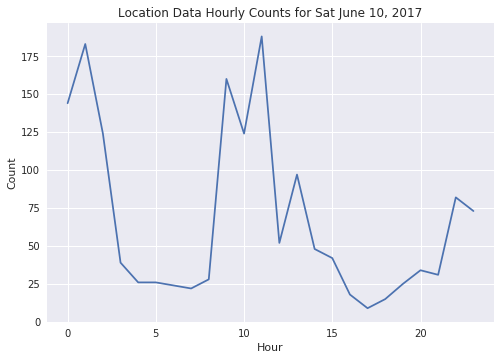

In [6]:
hour_counts_0610 = df_0610.groupby('local_hour').agg({'latitude': len}).rename(columns={'latitude':'count'}).reset_index()
fig = plt.figure()
plt.title('Location Data Hourly Counts for Sat June 10, 2017')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.plot(hour_counts_0610['local_hour'], hour_counts_0610['count']);

In [7]:
map_Sat = folium.Map(location=[40.7128, -74.0059],
                     zoom_start=11,
                     tiles='Stamen Toner')
n = len(df_0610['latitude'])

for i in range(n):
    if df_0610.loc[i,'model'] == 'iPhone':
        folium.RegularPolygonMarker([df_0610.loc[i,'latitude'], df_0610.loc[i,'longitude']], popup=str(df_0610.loc[i,'model'])+str(df_0610.loc[i,'local_time']), fill_color='red', number_of_sides=5, radius=5).add_to(map_Sat)
    elif df_0610.loc[i,'model'] == 'iPad':
        folium.RegularPolygonMarker([df_0610.loc[i,'latitude'], df_0610.loc[i,'longitude']], popup=str(df_0610.loc[i,'model'])+str(df_0610.loc[i,'local_time']), fill_color='blue', number_of_sides=3, radius=5).add_to(map_Sat)
map_Sat.save(os.path.join('', '0610_polygon.html'))

In [8]:
def firstn(n):
    num = 0
    while num < n:
        yield num
        num += 1

In [9]:
firstn(10)

<generator object firstn at 0x7ff4a52728c0>

In [10]:
x = firstn(10)
y=next(x)

In [11]:
y

0

In [12]:
y

0

In [13]:
next(x)

1

In [14]:
next(x)

2

In [16]:
print sum(firstn(1000000))

499999500000


In [17]:
w = xrange(10)

In [19]:
w.

xrange(10)

In [22]:
sum(range(100000000))

4999999950000000

In [23]:
sum(xrange(100000000))

4999999950000000